<a href="https://colab.research.google.com/github/therobinkay/gender_bias_2021/blob/main/Journal_Analysis_1_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import all necessary packages

import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "drive/My Drive"

In [ ]:
# read all necessary .csv files

data = pd.read_csv("drive/My Drive/codes/data.csv")
dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")
cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')
cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")
cen = pd.read_csv("drive/My Drive/codes/cen.csv")

# Analyses


## 1. Order of Author Analysis

In [ ]:
# excluding alphabetically sorted papers

# splitting the authors by first, second, middle, last positions

first = data.query('is_alpha == False & order == 1')
second = data.query('is_alpha == False & order == 2 & is_last == False')
middle = data.query('is_alpha == False & order > 2 & is_last == False')
last = data.query('is_alpha == False & order != 1 & is_last == True')

In [ ]:
# calculating gender ratio of each position

print(first['gender'].value_counts(normalize=True))
print(second['gender'].value_counts(normalize=True))
print(middle['gender'].value_counts(normalize=True))
print(last['gender'].value_counts(normalize=True))

male      0.917101
female    0.082899
Name: gender, dtype: float64
male      0.911277
female    0.088723
Name: gender, dtype: float64
male      0.906659
female    0.093341
Name: gender, dtype: float64
male      0.91497
female    0.08503
Name: gender, dtype: float64


## 2. Productivity by Gender


In [12]:
data.head()

,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
0,10.1103/PhysRevSeriesI.17.267,127898,male,2,2,True,False,1903,article,PRI
1,10.1103/PhysRev.5.269,127898,male,3,3,True,False,1915,article,PR
2,10.1103/PhysRevSeriesI.16.279,127898,male,2,2,True,False,1903,article,PRI
3,10.1103/PhysRevSeriesI.16.279,59048,male,1,2,False,False,1903,article,PRI
4,10.1103/PhysRevSeriesI.5.294,9710,male,1,2,False,False,1897,article,PRI


In [36]:
# Creating a DataFrame with productivity calculated
prod = data.groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])
prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

# Dividing the DataFrame by gender
prod_m = prod.xs('male', level='gender')
prod_fm = prod.xs('female', level='gender')

In [38]:
#ks test (two-tailed)
from scipy.stats import ks_2samp
print(ks_2samp(prod_m2['prod'], prod_fm2['prod']))

#ks test: male > female
print(ks_2samp(prod_m2['prod'], prod_fm2['prod'], alternative='greater'))

#ks test: male < female
print(ks_2samp(prod_m2['prod'], prod_fm2['prod'], alternative='less'))

Ks_2sampResult(statistic=0.0329418537762845, pvalue=0.000127997328482532)
Ks_2sampResult(statistic=0.0329418537762845, pvalue=6.244757804870422e-05)
Ks_2sampResult(statistic=0.019882369577186365, pvalue=0.029229651385167425)


In [37]:
# finding where the biggest difference occurs

def ks_2samp_x(data1, data2, alternative="two-sided"):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.argmin(cddiffs)   # ks_2samp uses np.min or np.max respectively 
    maxS = np.argmax(cddiffs)   # now we get instead the index in data_all
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d_arg = alt2Dvalue[alternative]
    return data_all[d_arg]

print(ks_2samp_x(prod_m['prod'], prod_fm['prod']))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="greater"))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="less"))

2.0
0.4857142857142857
2.0


## 3. Dropout Authors by Career Age
Don't include the authors who have not written anything before 1999.

(annual year is only showing less accurate dropout)

(0.0, 0.2)

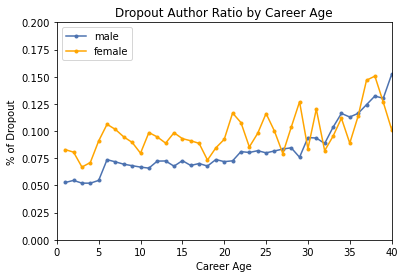

In [53]:
# exclude authors who enter APS publication after 2004
# create (JADIDI) scatterplot of dropout authors by career age

gb = prod[prod['year']['min'] < 2004].groupby(['gender', 'career_age'])['career_age'].count()

gb_m = gb['male'].sort_index(ascending=False)
gb_fm = gb['female'].sort_index(ascending=False)

(gb_m/gb_m.cumsum()).iloc[::-1].plot(style='.-')
(gb_fm/gb_fm.cumsum()).iloc[::-1].plot(style='.-',color='orange')

plt.title('Dropout Author Ratio by Career Age')
plt.legend(('male', 'female'), loc='upper left')
plt.xlabel('Career Age')
plt.xlim(0,40)
plt.ylabel('% of Dropout')
plt.ylim(0, 0.2)

## 4. Citation Analysis

### 4.1 Degree Centrality Analysis

In [54]:
# exclude alphabetically ordered papers
# only consider primary authors
degcen = data.query('is_alpha == False & order == 1')

# calculate degree centrality per paper
vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

# create a DataFrame with degree centrality
cited = pd.merge(cb_sub, degcen, left_index = True, right_on = 'doi')

Text(0, 0.5, 'Proportion of Female Primary Authors')

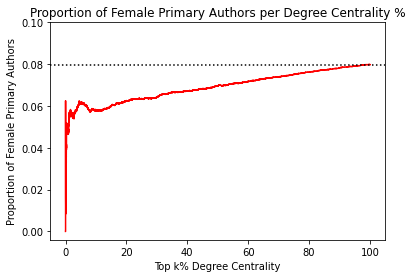

In [55]:
# Comparative graph for actual female proportion vs. expected female proportion
cited_gender = cited['gender'].to_numpy()
cumulate_cited_gender = np.cumsum(cited_gender == "female")

plt.plot((np.arange(len(cited))*100)/len(cited), cumulate_cited_gender/np.arange(1, len(cited)+1), color='red')
plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited), color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per Degree Centrality %")
plt.xlabel("Top k% Degree Centrality")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")

### 4.2 Self-citation Analysis (general)


---

정리 필요



In [64]:
# create a DataFrame with self-citing authors by gender
sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]

sc_m = cdata.loc[(cdata['citing_id'] == cdata['cited_id']) & (cdata['citing_gender'] == 'male')]

# sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

print(len(sc_m))
print(len(sc_fm))

# # group data points by publication year
# msc = sc_m.groupby(['citing_year'])['citing_year'].count()
# fmsc = sc_fm.groupby(['citing_year'])['citing_year'].count()

# # create overall self-citing author dataframes for ratio calculation
# cdata_m = cdata[cdata['citing_gender'] == 'male']
# cdata_fm = cdata[cdata['citing_gender'] == 'female']
# mcdata = cdata_m.groupby(['citing_year'])['citing_year'].count()
# fmcdata = cdata_fm.groupby(['citing_year'])['citing_year'].count()

524788
39572


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.15)

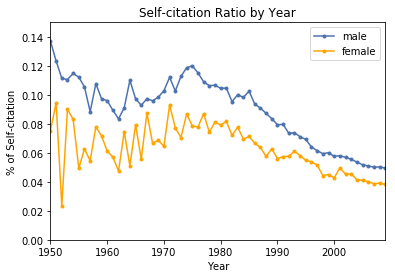

In [ ]:
# create a self-citation ratio plot by year
(msc/mcdata).plot(style='.-')
(fmsc/fmcdata).plot(style='.-',color='orange')

plt.title('Self-citation Ratio by Year')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.15)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


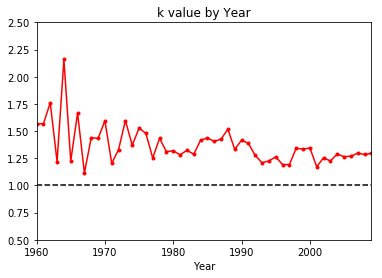

In [ ]:
# create overall self-citing author dataframes for ratio calculation with 0s
cdatacit = cdata.groupby(['citing_year'])['citing_year'].count()
cdatacit[np.isnan(cdatacit)] = 0
mcdata = cdata_m.groupby(['citing_year'])['citing_year'].count()
mcdata[np.isnan(mcdata)] = 0
fmcdata = cdata_fm.groupby(['citing_year'])['citing_year'].count()
fmcdata[np.isnan(fmcdata)] = 0

# create self-citing author by year dataframes for ratio calculation with 0s
sccit = sc_list.groupby(['citing_year'])['citing_year'].count()
sccit[np.isnan(sccit)] = 0
msc = sc_m.groupby(['citing_year'])['citing_year'].count()
msc[np.isnan(msc)] = 0
fmsc = sc_fm.groupby(['citing_year'])['citing_year'].count()
fmsc[np.isnan(fmsc)] = 0

# calculate k-value from Section 5.2
k1 = ((msc/sccit)/(fmsc/sccit))
k2 = ((fmcdata/cdatacit)/(mcdata/cdatacit))
k = k1*k2

# create k-value plot
k.plot(style='.-', color='red')

plt.title('k value by Year')
plt.xlabel('Year')
plt.xlim(xmin=1960)
plt.ylabel('k')
plt.ylim(ymin=0.5,ymax=2.5)
plt.hlines(1,xmin=1903,xmax=2009,linestyles='dashed')

## 6 PageRank Centrality

In [ ]:
# apply nx.graph to citation relationship network
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi', target='cited_doi', create_using=Graphtype)
print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 144813
Number of edges: 703005
Average in degree:   4.8546
Average out degree:   4.8546


In [ ]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['centrality'] = pr.values()

In [ ]:
# observe author id & gender (primary author)
nodedata = data[data['is_alpha'] == False]
nodedata = nodedata[nodedata['order'] == 1]
nodedata = nodedata.drop(['order', 'numAuthor',	'is_last',	'is_alpha',	'year',	'articleType',	'journal', 'id'], axis=1)
nodedata = nodedata.reset_index()
nodedata.columns = ['id', 'Label', 'Gender']
nodedata.head()

# merge and create a dataframe: id, gender, PageRank centrality
prs = prs.merge(nodedata, left_on='doi', right_on='Label', how='left')
prs = prs.drop(['doi', 'Label'], axis=1)
prs = prs[['id', 'Gender', 'centrality']]

# split the dataframe by gender
prs_m = prs[prs['Gender'] == 'male']
prs_fm = prs[prs['Gender'] == 'female']

In [ ]:
# create a comparative histogram for PageRank centrality by gender
plt.style.use('seaborn-deep')
bins = np.linspace(0, 0.0015, 50)

plt.hist([prs_m['centrality'], prs_fm['centrality']], bins, label=['male', 'female'], color=['blue','orange'])

plt.title("PageRank Centrality for Primary Authors")
plt.legend(loc='upper right')
plt.xlabel('Centrality')
plt.yscale('log')
plt.ylabel('log(count)')
plt.show()

Text(0, 0.5, 'Proportion of Female Primary Authors')

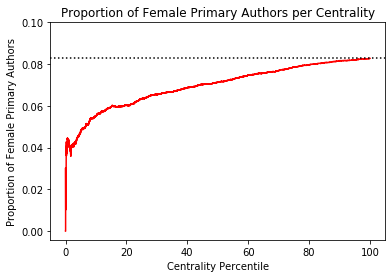

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion

prs_gender = prs['Gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

plt.plot((np.arange(len(prs))*100)/len(prs), cumulate_prs_gender/np.arange(1, len(prs)+1), color='red')
plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per Centrality")
plt.xlabel("top k% Centrality")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")